In [81]:
import torch
import numpy as np
from numpy.linalg import norm
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [82]:
def get_repeated_Indices(list_of_indices):
    #input: string of indices for the tensors. 
    #output: string of repeated indices. code takes in indices and output only the repeated indices
    #Ex: Suppose tensor A has index ijkp, and tensor B has index klpm.
    #then get_repeated_Indices('ijkp', 'klpm') will return the following string: 'kp'
    myList = list_of_indices
    #convert List to string
    myString =''.join(myList)
    #break the string into indivual list of characters ex.  'abc' ->['a','b', 'c']
    myList = list(myString)
    #get the repeated frequencies of each indices
    my_dict = {i:myList.count(i) for i in myList}
    
    repeatedList = []
    for item in my_dict:
        if my_dict[item] > 1:
            repeatedList.append(item)
    return repeatedList

def  remove_Repeated_indices(List_of_indices):
    #inputs: tensor indices in the form of string
    #output: string of non repeated indicies
    #Ex: remove_Repeated_indices('abc', 'cde')
    #output of the example would be: 'abde'
    
    myList = List_of_indices 
    #turn myList into String: Ex: ['abc','cde'] -> 'abccde'
    myString = ''.join(myList)
    #turn back into lists again: Exp: from 'abccde' -> ['a','b','c','c','d','e']
    myList = list(myString)
    repeated_indices = get_repeated_Indices(List_of_indices)
    #print('the repeated list of indices are:', repeated_indices)
    unique_indices = []
    #now we remove repeated indices from myList
    for item in myList:
        if item not in repeated_indices:
            unique_indices.append(item)
    uniqueString = ''.join(unique_indices)   
    return uniqueString

def einSum_Contraction(tensorList, indxList):  #<----should rename this to einSum_Contraction to replace old code
    #Purpose: this function takes a list of tensors, and list of indices, and indix to contract and uses einstien summation to perform contraction
    #ex: tensorList = [tensor1, tensor2, tensor3]
    #indxList   = [indx1, indx2, indx3]
    myList = []
    uniqueIndices = remove_Repeated_indices(indxList)
    inputIndices = [indxList]
    N = len(indxList)
    #myList = [indx1, ',',indx2,',',indx3,'->', uniqueIndices] 
    for i in range(N - 1):
        myList.append(indxList[i])
        myList.append(',') 
    myList.append(indxList[N-1])
    myList.append('->')
    myList.append(uniqueIndices)
    #convert myList to a string: i.e.  [indx1, ',',indx2,',',indx3,'->', uniqueIndices]  - >'ijk,klm,mjp->ilp'
    myString = ''.join(myList)
    #print('myString = ', myString)
    C = torch.einsum(myString, tensorList)
    return C

In [83]:
def padTensor(tensor, pad_axis):
    #this is for the discrete optimization
    #this function takes a tensor and append an extra dimension of ~ zeros along the specified axis (we call the pad axis)
    if pad_axis == -1:
        return tensor #don't pad anything
    tensorShape = list(tensor.shape)
    tensorShape[pad_axis] = 1  #increase the dimension up by 1
    zerosPad = torch.rand(tensorShape) *1e-6  #pad with values approx. equal to zero
    padded_tensor = torch.cat([tensor, zerosPad], pad_axis)
    #print('padded_tensor.shape = ', padded_tensor.shape)
    #print('padded_tensor function output = ', padded_tensor)
    return padded_tensor

In [84]:
def increaseRank(Tensor1, Tensor2, indx1, indx2):
    # The indx 1 and index2 represents the indices for tensor 1 and 2 respectively. 
    #There is only one repeated index in the list (indx1, indx2). The repeated index represents the shared edge between
    #the two tensors. For ex: ijkl, lmno
    alpha = get_repeated_Indices([indx1, indx2])
    if len(alpha) != 0 :
        #convert alpha to string
        alpha = ''.join(alpha)
        # find the position of the repeated index alpha in indx1 and indx2
        padAxes1 = indx1.index(alpha)
        padAxes2 = indx2.index(alpha)  
        Tensor1 = padTensor(Tensor1, padAxes1)
        Tensor2 = padTensor(Tensor2, padAxes2)
    return  Tensor1, Tensor2

In [85]:
def Tensor_Generator(TensorDimension):
#input: desired target tensor dimension in the form of a list. Ex: input d1xd2xd3 as [d1, d2, d3]
#output: target tensor with random entries drawn from a normal distribution of mean=0 and variance=1
    Tensor = torch.randn(TensorDimension)
    return Tensor

In [86]:
def getOneData_point(W):
# W is input tensor
#X are drawn from a normal distribution of mean=0 and variance=1 
#output: Xi, yi  = targetTensor * X
    indxList = []
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    Xi = Tensor_Generator(W.shape) #generate Tensor Xi with same shape as input tensor W
    for j in range(len(Xi.shape)):
        indxList.append(alphabet[j])
        indx = ''.join(indxList)
    tensorList = [W, Xi]
    #W and X have same index so that yi is a scaler
    yi = einSum_Contraction([W,Xi], [indx, indx])
    return Xi, yi, indx  #W and Xi shares the same indx

def data_Set_Generator(tensor, N):
    #N = number of training data you want
    #tensor is usually the target tensor 
    Xi_set = []
    yi_set = []
    for i in range(N):
        Xi, yi, indx = getOneData_point(tensor)
        Xi_set.append(Xi)
        yi_set.append(yi)
    return Xi_set, yi_set,indx  #tensor and Xi shares the same indx

def getYi_set(Xi_set, tensor, indxList):
    #this function generates a N number of yi's using yi = tensor*Xi_set[i]. 
    #The input tensor is usually either the approx. tensor or the target tensor.
    #indxList = [indx_Xi, indx_tensor]
    yi_set = []
    N = len(Xi_set)      #is there are N elements of Xi in Xi_set, there will be N elements of yi in yi_set
    for i in range(N):
        yi = einSum_Contraction([tensor,Xi_set[i]], indxList)
        yi_set.append(yi)
    return yi_set

In [87]:
def innerProduct_Tensor(T,A):
    #input: inner product of two tensors T and A of same dimension equals the sum of the product of their entries 
    #covert T, and A tensors in to 1 D tensors
    T = T.view(1,-1)   #convert tensor  to 1D
    T = T.squeeze()    #squeeze out any extra dimension
    A = A.view(1,-1)
    A = A.squeeze()
    #perform inner product of two 1D tensors
    yi = sum(torch.mul(T,A))
    return yi
    

In [88]:
def printRank(TensorList):
    [r5,r6,r7,r8] = (TensorList[4].shape) #tensor G dimension
    [r4,d4,r3,r5] = (TensorList[3].shape) #tensor D dimension
    [r2,d1,r1,r7] = (TensorList[0].shape) #tensor A dimension
    #print(' [r1, r2, r3,r4,r5,r6,r7,r8] = ', '[', r1, ',', r2, ',', r3, ',', r4, ',', r5,',', r6, ',', r7, ',', r8, ']')
    r = [r1,r2,r3,r4,r5,r6,r7,r8]
    return r


def getNumParams(r):
    #r = list of ranks of a tensor
    numParam = d1*r[0]*r[6]*r[1] + d2*r[0]*r[7]*r[3]+ d3*r[1]*r[5]*r[2] + d4*r[3]*r[4]*r[2] + r[4]*r[5]*r[6]*r[7]
    return numParam

def getNumParams_stoch(r):
    #r = [r0,r1,r2,r3,...,r7] 
    #we want to compuate the dimension of the block we start with. For exmape
    #we started with 4 order tensor, which can be approximated by 5 tensors
    #below computes the number of params for each of the tensor
    numParam1 = d1*r[0]*r[6]*r[1]
    numParam2 = d2*r[0]*r[7]*r[3]
    numParam3 = d3*r[1]*r[5]*r[2]
    numParam4 = d4*r[3]*r[4]*r[2]
    numParamCore = r[4]*r[5]*r[6]*r[7] 
    numParamList = [numParam1, numParam2, numParam3, numParam4, numParamCore]
    return numParamList

In [89]:
def computeLoss_Regression(yi_set, Xi_set, approxTensor):
    #N is total number of training/test data
    sum = 0
    N = len(yi_set)
    for i in range(N):
        # y_approx = innerProduct(ApproxTensor, X_i)
        y_approx = innerProduct_Tensor(approxTensor, Xi_set[i])
        loss = (yi_set[i] - y_approx)**2
        sum = sum + loss
    #divide by N to average the squared error of the cost function  so that the cost function doesn't depend on the number 
    #of elements in the training set.
    total_loss = 1/(2*N)*sum 
    return(total_loss)

In [90]:
def get_RandomSeqence(seqLength,d):
    #the function generates a random sequence of length 'seqLength' with range from 1 to range d.
    #For examplae, if we have 8 ranks, then seqLength. Code will generate 8 random numbers in the range between 
    #1 to d inclusive.
    r = []
    for i in range(seqLength):
        r.append(random.randint(1,d))
    return r

In [91]:
def get_Next_randomEdge(r_list):
    #this function is for random walk
    #input: r_list = [r0,r1,...r7] 
    nextDirection = random.randint(0, len(r_list)-1)
    print('nextDirection = ', nextDirection)
    r_list[nextDirection] = 1 + r_list[nextDirection]
    return r_list

In [92]:
def solve_Continuous(target_Tensor, tensorList, indxList, iterNum):
#input: list of tensors and their corresponding indices
#Goal: The purpose of this function is to solve the innerloop of the optimization for the problem
    len_Tensor = len(tensorList)
    len_Indx   = len(indxList)
    for i in range(len_Tensor):
        tensorList[i] = tensorList[i].detach()
        tensorList[i].requires_grad = True
    #defines a SGD optimizer to update the parameters
    #optimizer = optim.SGD(tensorList lr = 0.001, momentum=0.2)
    optimizer = optim.Adam(tensorList, lr=0.009)
    #initialize parameters      
    LostList = []              #use this to plot the lost function
    for i in range(iterNum):
        optimizer.zero_grad()
        tensor_approx = einSum_Contraction(tensorList, indxList)
        #loss_fn = computeLoss(tensor_approx, target_Tensor)   # this is for tensor decomp: ||W_target - W_approx||_Fˆ2
        loss_fn =computeLoss_Regression(yi_train, Xi_train, tensor_approx)
        loss_fn.backward()
        optimizer.step()                # the new A,B,C will be A_k+1,B_k+1, C_k+1 after optimizer.step 
        LostList.append(float(loss_fn))
    return tensorList, indxList, LostList

In [93]:
#generate 4-order target tensor
#see ipad for supplementary notes on this tensor and its diagram

#With Core tensor: 5 nodes
#****it will be interestingn to set r5 to r8 to get tucker structure and run the code to see how 
# the structure compares to tucker decomposition. Tucker decomposition could become another based cased
d1 = 3
d2 = 3
d3 = 3
d4 = 3
d5 = 3
r0 = 2
r1 = 3
r2 = 4
r3 = 3
r4 = 2
r5 = 3
r6 = 2
r7 = 2

noise = 1e-6
#generate at random target tensor

A = torch.rand(r1,d1,r0,r6) # + torch.rand(r1,d1,r0,r6)*noise
B = torch.rand(r0,d2,r3,r7) # + torch.rand(r0,d2,r3,r7)*noise
C = torch.rand(r1,d3,r2,r5) # + torch.rand(r1,d3,r2,r5)*noise
D = torch.rand(r3,d4,r2,r4) # + torch.rand(r3,d4,r2,r4)*noise 
G = torch.rand(r4,r5,r6,r7) # + torch.rand(r4,r5,r6,r7)*noise

indxA = 'kilc'
indxB = 'ljed'
indxC = 'khgb'
indxD = 'efga'
indxG = 'abcd'   #core tensor

indxList = [indxA, indxB, indxC, indxD, indxG]

target_Tensor = einSum_Contraction([A,B,C,D,G], [indxA, indxB, indxC, indxD, indxG])


#generate training and test sets
N=20
#p is the percentage of the total number of data N
p = int(np.floor(0.65*20))  #so is is 65% of the original data
[Xi_data, yi_data, indx] = data_Set_Generator(target_Tensor, N) 
Xi_train = Xi_data[0:p]
yi_train  = yi_data[0:p]
Xi_test = Xi_data[p:N+1]
yi_test = yi_data[p:N+1]

In [94]:
#following data are used for initializing Greedy method

#initilize data
r1 = 1
r2 = 1
r3 = 1
r4 = 1
r5 = 1
r6 = 1
r7 = 1
r8 = 1

#initialize tensor 
A_0 = torch.rand(r2,d1,r1,r7)
B_0 = torch.rand(r1,d2,r4,r8)
C_0 = torch.rand(r2,d3,r3,r6) 
D_0 = torch.rand(r4,d4,r3,r5) 
G_0 = torch.rand(r5,r6,r7,r8)

#target_Tensor = einSum_Contraction([A_0,B_0,C_0,D_0,G_0], [indxA, indxB, indxC, indxD, indxG])


TensorList = [A_0,B_0,C_0,D_0,G_0] 
TensorList_temp = [A_0,B_0,C_0,D_0,G_0] #TensorList[:]

#index list: we use the same indexlist as the ones defiined for target tensor

In [95]:
############################### MAIN LOOP FOR GREEDY #####################

#Initialize data
iterNum=100   #500
Lost_star = 1e12  #set it to be any large number
check = 1
maxParam = d1*d2*d3*d4
numParam = -1
paramKey = -1
G = []

for k in range(5):
    if paramKey == 1:
        break
    for i in range(len(TensorList_temp)):
        if paramKey == 1:
            break
        for j in range(i,len(TensorList_temp)):
            if paramKey == 1:
                break
            if i==j:
                continue
            #print(i,j)
            #increase the ranks of the tensors
            [TensorList_temp[i],TensorList_temp[j]] = increaseRank(TensorList_temp[i], TensorList_temp[j],  indxList[i], indxList[j])            
            #check num of paramters for the newly updated ranks
           # rt = list of ranks: [r1_t,r2_t,r3_t,r4_t,r5_t,r6_t,r7_t,r8_t]
            rt = printRank(TensorList_temp)
            numParam_temp = getNumParams(rt)
            print('numParam_greedy=', numParam_temp)
            if numParam_temp > maxParam:
                paramKey = 1
                print('Max number of parameters exceeded. Current Param = ', numParam_temp, 'and max Param allowed = ', maxParam)
                print('program finish ')
                break
            #solve continuous part
            [TensorList_temp, indxList, LostList] = solve_Continuous(target_Tensor, TensorList_temp, indxList, iterNum)
            printRank(TensorList_temp)
            #store the optimal value for a given point around its neighbour
            if Lost_star > LostList[-1]: 
                    indx_star = [i,j]
                    TensorList_star = TensorList_temp[:]
                    indxList_star = indxList[:]  
                    Lost_star = LostList[-1]  
                    r_greedy = printRank(TensorList_star)
                    print('r_greedy = ', r_greedy)
                    numParam = getNumParams(r_greedy )
                    check = -1
            elif Lost_star <= LostList[-1]:
                print('k = ', k, 'Prev Loss = ', Lost_star, 'Current Loss = ', LostList[-1])
                print('Loss previous is less than current, so no rank update is made at this iteration')
                print('total number of parameters for best chosen rank = ', numParam)
         
            #Reset TensorList_temp to continue with greedy at another point
            TensorList_temp = TensorList[:] #set back to previous position to continue with greedy search        
    #update parameters   
    TensorList_temp = TensorList_star[:]    #everything is behaving as expected
    indxList = indxList_star[:]     # don't really need to update this cause these don't really change
    TensorList_greedy   = TensorList_star[:]  #everything is behaving as expected
    G.append(Lost_star)
    

numParam_greedy= 19
r_greedy =  [2, 1, 1, 1, 1, 1, 1, 1]
numParam_greedy= 19
r_greedy =  [1, 2, 1, 1, 1, 1, 1, 1]
numParam_greedy= 13
r_greedy =  [1, 1, 1, 1, 1, 1, 1, 1]
numParam_greedy= 17
r_greedy =  [1, 1, 1, 1, 1, 1, 2, 1]
numParam_greedy= 13
r_greedy =  [1, 1, 1, 1, 1, 1, 1, 1]
numParam_greedy= 19
r_greedy =  [1, 1, 1, 2, 1, 1, 1, 1]
numParam_greedy= 17
k =  0 Prev Loss =  0.3837956488132477 Current Loss =  8.13695240020752
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 19
k =  0 Prev Loss =  0.3837956488132477 Current Loss =  1.7003014087677002
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  19
numParam_greedy= 17
k =  0 Prev Loss =  0.3837956488132477 Current Loss =  8.136640548706055
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for 

k =  4 Prev Loss =  0.000998261384665966 Current Loss =  8.137063026428223
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  55
numParam_greedy= 19
k =  4 Prev Loss =  0.000998261384665966 Current Loss =  6.680768966674805
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  55
numParam_greedy= 17
k =  4 Prev Loss =  0.000998261384665966 Current Loss =  8.13808536529541
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  55
numParam_greedy= 19
k =  4 Prev Loss =  0.000998261384665966 Current Loss =  2.155329942703247
Loss previous is less than current, so no rank update is made at this iteration
total number of parameters for best chosen rank =  55
numParam_greedy= 17
k =  4 Prev Loss =  0.000998261384665966 Current Loss =  8.136563301086426
Loss previ

In [96]:
#GREEDY script continue
#TensorList contains decomposed block of tensors. We use einsum to combine them into one 
#big tensor Tapprox_greedy
Tapprox_greedy = einSum_Contraction(TensorList_greedy, indxList)  #TensorList_Greedy = TensorList
print('Tapprox_greedy.shape = ', Tapprox_greedy.shape)

#generate yi_approx = tensorApprox_star * X_i. Plot this set of yi_approx, with yi
indxlist_greedy = ['abcd', 'abcd']   # abcd =  = d1*d2*d3*d4 i.e. each alphabet represents each dimension ot target tensor
yi_approxSet_greedy = getYi_set(Xi_test, Tapprox_greedy, indxlist_greedy)
print('len(yi_approxSet_greedy) = ', len(yi_approxSet_greedy))

Tapprox_greedy.shape =  torch.Size([3, 3, 3, 3])
len(yi_approxSet_greedy) =  7


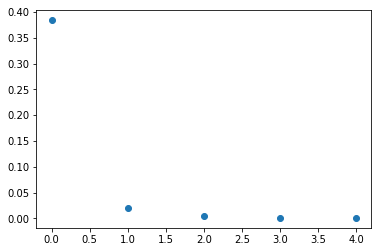

greedy: G =  [0.3837956488132477, 0.020550517365336418, 0.004363940097391605, 0.001709083328023553, 0.000998261384665966]


In [105]:
 # plot for all the greedy loops
    #import matplotlib.pyplot as plt
plt.figure()
plt.plot(G, 'o')
plt.show()
print('greedy: G = ', G)

In [98]:
#***********************STOCHASTIC APPROACH MAIN******************************************

#The following main program assigns random values to each of the 8 ranks and computes the continuos optimization
#part. It repeats 8 times (8 trials) and selects the trial with the smallest lost.

#initilize data
iterNum=100   #500
maxParam = d1*d2*d3*d4
#print('maxParam = ', maxParam) 
L = []
#generate sequence of random ranks between 1 to 8
numRank = 8
d=4  #highest dimension you want to explore
max_numShots = 15  #number of random trials you want to perform
dmax = max(d1,d2,d3,d4)
numShots = 0
LostList_prev = 1e12

#for i in range(numShots):
while numShots <max_numShots:
    r_stoch = get_RandomSeqence(numRank,d)
    #initialize tensor 
    A_0 = torch.rand(r_stoch[1],d1,r_stoch[0],r_stoch[6])
    B_0 = torch.rand(r_stoch[0],d2,r_stoch[3],r_stoch[7])
    C_0 = torch.rand(r_stoch[1],d3,r_stoch[2],r_stoch[5])
    D_0 = torch.rand(r_stoch[3],d4,r_stoch[2],r_stoch[4]) 
    G_0 = torch.rand(r_stoch[4],r_stoch[5],r_stoch[6],r_stoch[7])
    TensorList_temp = [A_0,B_0,C_0,D_0,G_0] #TensorList[:]   
    #the following if loop checks the number of elements of each A_0, ..., G_0
    #does not exceed the total number elements of target tensor
    #numParamList = getNumParams(r_stoch)
    #if maxParam > numParamList[0] and maxParam > numParamList[1] and maxParam > numParamList[2] and maxParam > numParamList[3] and maxParam > numParamList[4]:
    if maxParam > getNumParams(r_stoch):
        [TensorList_temp, indxList, LostList] = solve_Continuous(target_Tensor, TensorList_temp, indxList, iterNum)
        L.append(LostList[-1])
        numShots += 1
        #the following if-loop stores the approx tensor that gives the smallest loss
        if LostList[-1] <LostList_prev:
            tensorApprox_star = TensorList_temp[:]
            LostList_prev = LostList[-1]
            r_Star = r_stoch       
print('Stochastic Method: best rank r = ', r_Star, 'with loss = ', LostList_prev)

Stochastic Method: best rank r =  [1, 2, 2, 2, 1, 2, 1, 4] with loss =  221.47479248046875


In [99]:
#...STOCHASTIC SCRIPT CONTINUE
#tensorApprox_star consists of blocks of tensor. We take tensor product of all these
#blocks to get one big block: TensorApprox_Stoch
indxList = [indxA, indxB, indxC, indxD, indxG]  #use the exact same indxList as the ones above
TensorApprox_Stoch = einSum_Contraction([tensorApprox_star[0],tensorApprox_star[1],tensorApprox_star[2],tensorApprox_star[3],tensorApprox_star[4]], [indxA, indxB, indxC, indxD, indxG])

#generate yi_approx = tensorApprox_star * X_i. 
indxlist_stoch = [indx, indx]   # indx_Xi = indx_W = indx. 
yi_approxSet_stoch = getYi_set(Xi_test, TensorApprox_Stoch, indxlist_stoch)

In [100]:
#################################Random Walk(RW) main###############################
maxParam = d1*d2*d3*d4
iterNum = 100
#initialize the edges to 1
r_RW = [1,1,1,1,1,1,1,1]
numParam_RW = getNumParams(r_RW)
Lost_starRW = 1e12  #set it to be any large number
G_RW = []
while maxParam > numParam_RW:
    print('r_RW =', r_RW)
    r_RW = get_Next_randomEdge(r_RW)
    numParam_RW = getNumParams(r_RW)
    #initialize tensor 
    if maxParam > numParam_RW:
        A_0 = torch.rand(r_RW[1],d1,r_RW[0],r_RW[6])
        B_0 = torch.rand(r_RW[0],d2,r_RW[3],r_RW[7])
        C_0 = torch.rand(r_RW[1],d3,r_RW[2],r_RW[5])
        D_0 = torch.rand(r_RW[3],d4,r_RW[2],r_RW[4]) 
        G_0 = torch.rand(r_RW[4],r_RW[5],r_RW[6],r_RW[7])
        TensorList_RW = [A_0,B_0,C_0,D_0,G_0]
        [TensorList_RW, indxList, LostList_RW] = solve_Continuous(target_Tensor, TensorList_RW, indxList, iterNum)
        G_RW.append(LostList_RW[-1])

print('Random Walk: numParam = ', numParam_RW, 'maxNumParam of target tensor = ', maxParam)
print('G_RW = ', G_RW)

#take the block tensors and combine them to form 1 big tensor: TensorApprox_RW 
indxList = [indxA, indxB, indxC, indxD, indxG]  #use the exact same indxList as the ones above
TensorApprox_RW = einSum_Contraction([TensorList_RW[0], TensorList_RW[1], TensorList_RW[2], TensorList_RW[3], TensorList_RW[4]], [indxA, indxB, indxC, indxD, indxG])
indxlist_RW = ['abcd', 'abcd']   # abcd =  = d1*d2*d3*d4 i.e. each alphabet represents each dimension ot target tensor
yi_approxSet_RW = getYi_set(Xi_test, TensorApprox_RW, indxlist_RW)


r_RW = [1, 1, 1, 1, 1, 1, 1, 1]
nextDirection =  5
r_RW = [1, 1, 1, 1, 1, 2, 1, 1]
nextDirection =  0
r_RW = [2, 1, 1, 1, 1, 2, 1, 1]
nextDirection =  5
r_RW = [2, 1, 1, 1, 1, 3, 1, 1]
nextDirection =  4
r_RW = [2, 1, 1, 1, 2, 3, 1, 1]
nextDirection =  6
r_RW = [2, 1, 1, 1, 2, 3, 2, 1]
nextDirection =  0
r_RW = [3, 1, 1, 1, 2, 3, 2, 1]
nextDirection =  5
r_RW = [3, 1, 1, 1, 2, 4, 2, 1]
nextDirection =  7
Random Walk: numParam =  86 maxNumParam of target tensor =  81
G_RW =  [9984.0439453125, 6356.84033203125, 2429.841796875, 2011.295166015625, 1716.7403564453125, 1679.0604248046875, 622.0523071289062]


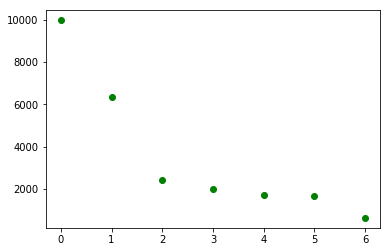

In [101]:
##PLOT FOR RANDOM WALK. X-AXIS = total number of steps and Y-axis = LostList[-1]
import matplotlib.pyplot as plt
plt.figure()
plt.plot(G_RW, 'og')
plt.show()

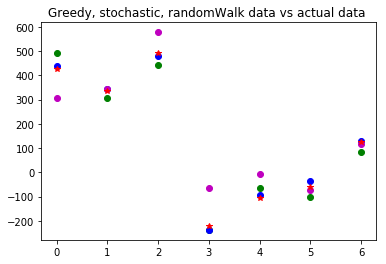

Legend
red: actual data
green: predicted data using stochastic
blue: predicted data using greedy
magenta: predicted data using random walk


In [102]:
#we assume yi_actual = yi_train. 
#The following plot compares the approx yi using different the 3 different approach (greedy, stochastic, random walk)
# and compare the approx to the actual data
import matplotlib.pyplot as plt
plt.figure()
plt.plot(yi_approxSet_stoch, 'og')
plt.plot(yi_approxSet_greedy, 'ob')
plt.plot(yi_approxSet_RW, 'om')
plt.plot(yi_test, '*r')   #recall we treat yi_test as our true data
plt.title('Greedy, stochastic, randomWalk data vs actual data ',loc='center')
plt.show()

print('Legend')
print('red: actual data')
print('green: predicted data using stochastic')
print('blue: predicted data using greedy')
print('magenta: predicted data using random walk')

In [103]:
# Compute RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
RMSE_stoch = sqrt(mean_squared_error(yi_test,yi_approxSet))
print('RMSE_stoch = ',RMSE_stoch)

RMSE_greedy = sqrt(mean_squared_error(yi_test,yi_approxSet_greedy))
print('RMSE_greedy = ',RMSE_greedy) 

RMSE_RW = sqrt(mean_squared_error(yi_test,yi_approxSet_RW))
print('RMSE_randomWalk = ',RMSE_RW) 

RMSE_stoch =  770.2573320784259
RMSE_greedy =  14.378347850711158
RMSE_randomWalk =  89.64448568905128


In [104]:
#relative error
def getRelError(yi_actual,yi_pred):
# Both yi_actual,yi_pred are a set of elements
    summ = 0
    nm = 0
    N = len(yi_actual)
    for i in range(N):
        summ = summ + abs(yi_actual[i] - yi_pred[i])
        nm = nm + abs(yi_actual[i])
    return summ/nm*100 

RE_stoch = getRelError(yi_test,yi_approxSet_stoch)
print('stoch Method: % rel. error = ', RE_stoch)

RE_greedy = getRelError(yi_test,yi_approxSet_greedy)
print('Greedy Method: % rel. error = ', RE_greedy)

RE_RW = getRelError(yi_test,yi_approxSet_RW)
print('Random Walk Method: % rel. error = ', RE_RW)

stoch Method: % rel. error =  tensor(15.9501, grad_fn=<MulBackward0>)
Greedy Method: % rel. error =  tensor(5.1030, grad_fn=<MulBackward0>)
Random Walk Method: % rel. error =  tensor(27.7737, grad_fn=<MulBackward0>)
